# Spacetime Initial Conditions

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


In [53]:
# defining some constants; G = c = 1

a = 0 # spin; |a| < 1
q = 0 # charge; 0 < q < 1; a^2 + q^2 < 1
M = 1 # mass;
rs = 2*M # schwarzchild radius; rs = 2GM/c^2

th0 = np.pi/2. # midplane of system

rh = M + np.sqrt(M**2 - a**2 - q**2) # radius of event horizon
risco = 3*rs # defining the ISCO - we are assuming non-spinnin BH so this is easy

In [54]:
# define coordinate grid: r x theta x phi = 100 x 100 x 100

## all arrays should have dimensions r x theta x phi

n1 = 2560 # cells in the r direction
n2 = 256 # cells in the theta (polar coordinate) direction
n3 = 1 # cells in the phi direction - we also use 2D geometry to match the simulations

In [55]:
## defining the metric

# creating the metric array (g_mu_nu)
g = np.zeros((4,4,n1,n2,n3))


sm = 0.001
rmax = 3000

r = np.zeros((n1,n2,n3))
th = np.zeros((n1,n2,n3))
ph = np.zeros((n1,n2,n3))

r_ = np.logspace(np.log10(rh+sm), np.log10(rmax), n1, base = 10.0)
th_ = np.linspace(sm, np.pi-sm, n2)
ph_ = np.linspace(sm, 2*np.pi-sm,n3)

In [56]:
### Filling in our coordinate grid

for j in range(n2):
    for k in range(n3):
        r[:,j,k] = r_
        
for i in range(n1):
    for k in range(n3):
        th[i,:,k] = th_        

for i in range(n1):
    for j in range(n2):
        ph[i,j,:] = ph_

In [57]:
# rotation rate as defined in Chakrabarti 1985 and Penna et al. 2005
## this is very important: typically between 0.707 and 0.710
xi = 0.7080
kap = 0.00766 # entropy constant
gam = 1.4444 # our adiabatic index 

## same choices as Penna et al.
rin = 6
r1 = 42
r2 = 1000
rout = 1000

rin_ind = (np.abs(r_-rin)).argmin()
r1_ind = (np.abs(r_-r1)).argmin()
r2_ind = (np.abs(r_-r2)).argmin()
rout_ind = (np.abs(r_-rout)).argmin()
risco_ind = (np.abs(r_-risco)).argmin()

In [58]:
delta = r**2 - 2*M*r + a**2 + q**2 # (FM 3.5)
sigma = r**2 + a**2 * np.cos(th)**2 # (FM 3.5)
A = (r**2 + a**2)**2 - delta * a**2 *(np.sin(th)**2) # (FM 3.5)


# constants for the inner edge of the accretion disk
delta0 = rin**2 - 2*M*rin + a**2 + q**2 # (FM 3.5)
sigma0 = rin**2 + a**2 * np.cos(th0)**2 # (FM 3.5)
A0 = (rin**2 + a**2)**2 - delta0*(a**2)*(np.sin(th0)**2)

In [91]:
## kerr-newman metric in BL coordinates
"""
In this case we have these assumptions:
- G = c = M = 1 (scale independent)
- a = q = 0 (no charge or spin)


"""

g[0][0] = 2*r/sigma - 1 # dt^2
g[0][1] = 0 # dt dr
g[0][2] = 0 # dt dtheta
g[0][3] = -2*M*a*r*(np.sin(th)**2)/sigma # dt dphi

g[1][0] = 0 # dr dt
g[1][1] = sigma/delta # dr^2
g[1][2] = 0 # dr dtheta
g[1][3] = 0 # dr dphi

g[2][0] = 0 # dtheta dt
g[2][1] = 0 # dtheta dr
g[2][2] = sigma # dtheta^2
g[2][3] = 0 # dtheta dphi

g[3][0] = -2*M*a*r*(np.sin(th)**2)/sigma # dphi dt
g[3][1] = 0 # dphi dr
g[3][2] = 0 # dphi dtheta
g[3][3] = A*(np.sin(th)**2)/sigma # dphi^2

# metric is symmetric g[i][j] = g[j][i]

## determinant of the matrix is given by
gdet = g[0][0]*g[1][1]*g[2][2]*g[3][3]

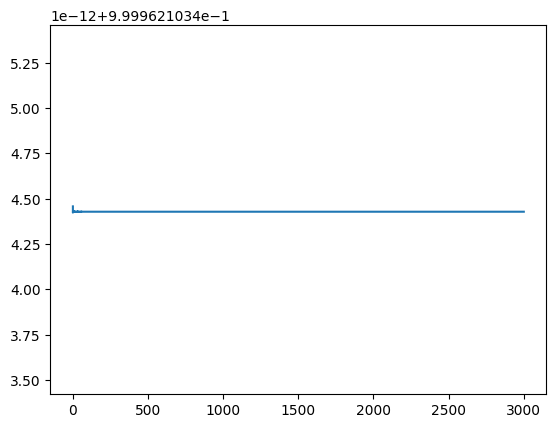

In [101]:
plt.plot(r_, -gdet[:,int(n2/2),0]/r_**4)

#plt.xscale('log')
#plt.yscale('log')

In [60]:
## needed terms from the metric
g_tt = g[0][0]
g_tp = g[0][3]
g_pp = g[3][3]

lam = np.sqrt(-g_pp/g_tt)
inner = (lam < r1)
outer = (lam > r2)
disk = np.ones_like(r) - inner - outer

In [61]:
def l_mom(r, r1, r2, th):
    """
    Function to return the specific angular momentum value given a coordinate system and inner and outer
    boundaries for the accretion disk
        inputs: 
            r = r coordinate with all 3 dimensions (r * theta * phi)
            r1 = inner region of disk
            r2 = outer region of accretion disk
            th = theta coordinate
        outputs:
            angular momentum value for given lambda(s)
    """
    
    F_ = 1
    G_ = 1 - 2/r

    Fin = 1
    Fout = 1
    Gin = 1 - 2/r1
    Gout = 1 - 2/r2
    
    lamin = lam[r1_ind,int(n2/2),0]
    lamout = lam[r2_ind,int(n2/2),0]

    mom2 = xi*np.sqrt(lam)*(F_/G_)*disk
    mom1 = xi*np.sqrt(lamin)*(Fin/Gin)*inner
    mom3 = xi*np.sqrt(lamout)*(Fout/Gout)*outer 
    ang_mom = mom2 + mom1 + mom3
    
    ## keplerian velocity profile is r^-0.5. Keplerian angular momentum prof is r^0.5
    
    return ang_mom

def F_func(r,th,omega,l,I):
    """
    
    
    
    """
    import scipy as scp
    from scipy.integrate import quad
    
    rin = 10

    dldr = (0.5*lam**(-0.5)*(1-2/lam) - 2*lam**(-1.5))/((1-2/lam)**2)

    def integrand(x, i1,i2):
        return (omega[i1,i2]/(1 - omega[i1,i2]*l[i1,i2])) * dldr[i1,i2]

    power = np.zeros_like(r)
    
    for i1 in range(0,n1):
        for i2 in range(0,n2):
            power[i1,i2,0] = quad(integrand, rin, lam[i1,i2], args=(i1,i2))[0]
    
    return (1 - omega*l) * np.exp(power)

# Calculating Initial Conditions

## Fishbone-Moncrief

In [62]:
rin = 6

In [63]:
## angular momentum definition from FM 3.7
top = r**4 + r**2 * a**2 - 2*M*r*a**2 - a*((M*r)**0.5) * (r**2 - a**2)
bot = r**2 - 3*M*r + 2*a*(M*r)**0.5

l_fm = (M/r**3)**0.5 * (top/bot)


## FM (3.5)
e_2nu = sigma*delta/A
e_2psi = np.sin(th)**2 * A/sigma
e_neg2chi = e_2nu/e_2psi
omega = 2*a*M*r/A

var_a = np.sqrt(1+ 4*l_fm**2 * e_neg2chi)
var_b = 0.5*np.log((1+var_a)/(sigma*delta/A))
var_c = - 0.5*var_a
var_d = - omega*l_fm

lnh1 = var_b + var_c + var_d ## (Fishbone Moncrief/ 3.5)
    
lnh0 = lnh1[rin_ind, int(n2/2),0]

lnh = lnh1 - lnh0 ## (Fishbone Moncrief 3.5)

w_fm = np.exp(lnh)

In [64]:
rho_amp = 1
gam = 1.444444

pgas_over_rho = (gam - 1.0) / gam * (w_fm - 1)
rho_fm = rho_amp * pgas_over_rho** (1.0 / (gam - 1.0))
pgas_fm = pgas_over_rho * rho_fm


## Chakrabarti

In [65]:
# rotation rate as defined in Chakrabarti 1985 and Penna et al. 2005
## this is very important: typically between 0.707 and 0.710
xi = 0.7080
kap = 0.00766
gam = 1.4444

## same choices as Penna et al.
rin = 10
r1 = 42
r2 = 1000
rout = 1200

rin_ind = (np.abs(r_-rin)).argmin()
r1_ind = (np.abs(r_-r1)).argmin()
r2_ind = (np.abs(r_-r2)).argmin()
rout_ind = (np.abs(r_-rout)).argmin()

## needed terms from the metric
g_tt = g[0][0]
g_tp = g[0][3]
g_pp = g[3][3]

lam = np.sqrt(-g_pp/g_tt)
inner = (lam < r1)
outer = (lam > r2)
disk = np.ones_like(r) - inner - outer

In [66]:
I = ((1-(xi**2)/r2)/(1-(xi**2)/r1))**0.5

In [67]:
rin = 10

F_ = 1
G_ = 1 - 2/r

l_chakra = np.sqrt(lam)*(F_/G_)
#l_chakra = (l_chakra+l_pen)/2

omega_c = -(l_chakra*g_tt)/(g_pp)

A_c = (-g_tt - g_pp*omega_c**2)**(-0.5) ## = u^t

In [68]:
I = ((1-(xi**2)/r2)/(1-(xi**2)/r1))**0.5

F_chakra = F_func(r, th, omega_c, l_chakra, I) ## idk what this physically is tbh

In [69]:
W = -np.log(F_chakra*A_c)
W_in = W[rin_ind, int(n2/2), 0]
w_chakra = np.exp(-W)

In [70]:
rho_amp = 1
gam = 1.44444444


pgas_over_rho = (gam - 1.0) / gam * (w_chakra-1)
rho_chakra = rho_amp * pgas_over_rho** (1.0 / (gam - 1.0))
pgas_chakra = pgas_over_rho * rho_chakra


"""
gam = 1.44444444
eps_chakra = (w_chakra-1)/gam
k=0.00766
rho_chakra = ((gam - 1)*eps_chakra/k)**(1/(gam-1))

density_floor = 0.001
pressure_floor = 0.001

pgas_chakra = np.nan_to_num(pgas_chakra2) + pressure_floor
rho_chakra = np.nan_to_num(rho_chakra2) + density_floor
"""

'\ngam = 1.44444444\neps_chakra = (w_chakra-1)/gam\nk=0.00766\nrho_chakra = ((gam - 1)*eps_chakra/k)**(1/(gam-1))\n\ndensity_floor = 0.001\npressure_floor = 0.001\n\npgas_chakra = np.nan_to_num(pgas_chakra2) + pressure_floor\nrho_chakra = np.nan_to_num(rho_chakra2) + density_floor\n'

## Penna

In [71]:
# rotation rate as defined in Chakrabarti 1985 and Penna et al. 2005
## this is very important: typically between 0.707 and 0.710
xi = 0.7080
kap = 0.00766
gam = 1.4444

## same choices as Penna et al.
rin = 10
r1 = 42
r2 = 1000
rout = 1200

rin_ind = (np.abs(r_-rin)).argmin()
r1_ind = (np.abs(r_-r1)).argmin()
r2_ind = (np.abs(r_-r2)).argmin()
rout_ind = (np.abs(r_-rout)).argmin()

## needed terms from the metric
g_tt = 2*r/sigma - 1
g_tp = g[0][3]
g_pp = A*(np.sin(th)**2)/sigma # dphi^2

lam = np.sqrt(-g_pp/g_tt)
inner = (lam < r1)
outer = (lam > r2)
disk = np.ones_like(r) - inner - outer

In [73]:
l_penna = l_mom(r,r1,r2,th)
omega_pen = -(l_penna*g_tt)/(g_pp)

In [76]:
I = ((1-(xi**2)/r2)/(1-(xi**2)/r1))**0.5

A_pen = (-g_tt - g_pp*omega_pen**2)**(-0.5) ## = u^t
F_pen = F_func(r,th,omega_pen,l_penna,I) ## idk what this physically is tbh

A_in = A_pen[rin_ind, int(n2/2), 0]
F_in = F_pen[rin_ind, int(n2/2), 0]

In [77]:
W = -np.log(F_pen*A_pen)

W_in = W[rin_ind, int(n2/2), 0]

w_penna = np.exp(-W+W_in) * ((lam>risco)*(r>3))

In [78]:
gam = 1.44444444
eps_penna = (w_penna-1)/gam
k=0.00766
rho_penna = ((gam - 1)*eps_penna/k)**(1/(gam-1))

In [79]:
rho_amp = 1
gam = 1.44444444

pgas_over_rho = (gam - 1.0) / gam * (w_penna-1)
rho_penna = rho_amp * pgas_over_rho** (1.0 / (gam - 1.0))
pgas_penna = pgas_over_rho * rho_penna

# Plotting

## Enthalpy Comparison

### 1D plots

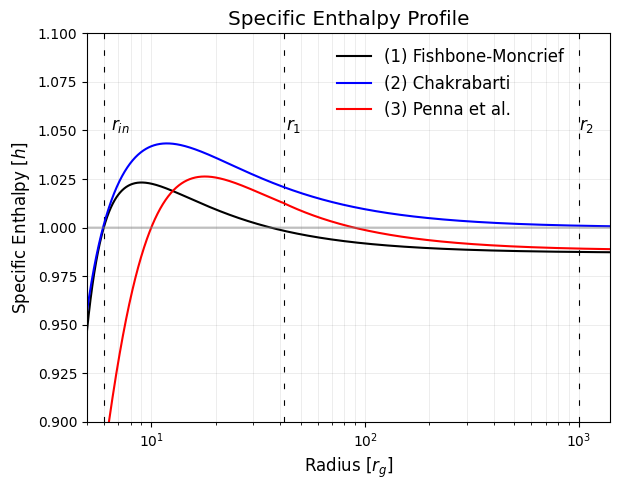

In [102]:
"""
Setting up axes and grid
------------------------
"""

plt.figure(figsize = (6.3,5))

#plt.tick_params(direction='in', grid_color='grey', grid_alpha=0.5, which = 'both')
plt.grid(color='black', linestyle='-', linewidth=0.5, alpha = 0.1, which = 'both')

"""
Plotting the important radii
----------------------------
"""

pos = 1.05
gap = 0.5
ls = (0,(5,10))
lw = 0.8


#plt.axvline(x = rh, color = 'black', linestyle = ls, label = 'r_h', lw = lw)
#plt.text(rh+gap, pos,r'$r_h$',rotation=0, size='large')
plt.axvline(x = rin, color = 'black', linestyle = ls, lw = lw)
plt.text(rin + gap, pos,r'$r_{in}$',rotation=0, size='large')
plt.axvline(x = r1, color = 'black', linestyle = ls, lw = lw)
plt.text(r1 + gap, pos,r'$r_1$',rotation=0, size='large')
plt.axvline(x = r2, color = 'black', linestyle = ls, lw = lw)
plt.text(r2 + gap, pos,r'$r_2$',rotation=0, size='large')
#plt.axvline(x = 1000, color = 'black', linestyle = ls, label = 'rout', , lw = lw)
#plt.text(1000+0.1,pos,r'$r_{out}$',rotation=0, size='large')

"""
Plotting the actual profile
---------------------------
"""

plt.plot(r_, w_fm[:,int(n2/2),0], color = 'black', label='(1) Fishbone-Moncrief')
plt.plot(r_, w_chakra[:,int(n2/2),0], color = 'blue', label='(2) Chakrabarti')
plt.plot(r_, w_penna[:,int(n2/2),0], color = 'red', label='(3) Penna et al.')

"""
Adding labels, limits, and scales
---------------------------------

"""

""" 
x-axis
"""

plt.xlim(risco-1,1400)
plt.xscale('log')
plt.xlabel("Radius [$r_g$]", fontsize='large')


"""
y-axis
"""
plt.ylabel(r"Specific Enthalpy [$h$]", fontsize='large')
plt.ylim(0.9,1.1)
#plt.yscale('log')

"""
title
"""
plt.title(r"Specific Enthalpy Profile", fontsize = 'x-large')

"""
Line at 1 - enthalpy must be above 1 within the accretion disk
"""

plt.plot(r_, np.ones_like(r_), color = 'grey', alpha = 0.5)

plt.legend(frameon = False, fontsize='large', bbox_to_anchor=(0.45, 1), loc='upper left')

plt.tight_layout()

plt.savefig("./EnthalpyProfile.pdf", format = 'pdf')

### Contour Plots

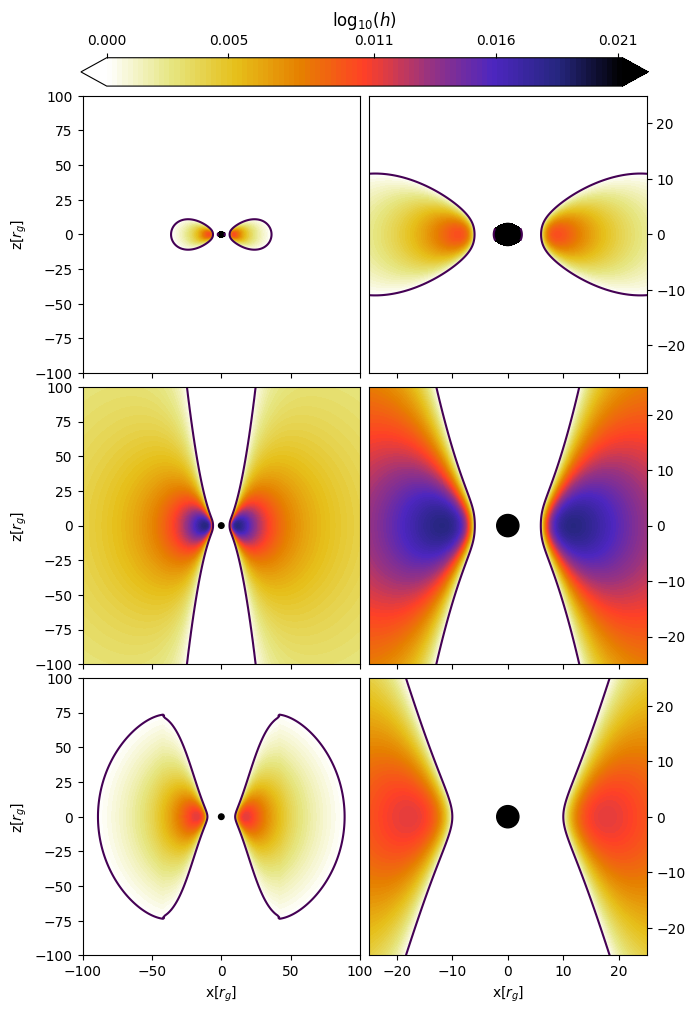

In [81]:
import warnings
warnings.filterwarnings("ignore")

mpl.rcParams['xtick.direction'] = "out"
mpl.rcParams['ytick.direction'] = "out"


cmap = 'CMRmap_r'
clr = 'white'

rows = 3
cols = 2

x = r[:,:,0]*np.sin(th[:,:,0])
y = r[:,:,0]*np.cos(th[:,:,0])

lnh1 = np.log10(w_fm*(lam>5))
lnh2 = np.log10(w_chakra*(lam>5.5))
lnh3 = np.log10(w_penna)
lnhs = [lnh1, lnh2, lnh3]

fmin = 0 #np.percentile(lnh, 15)
fmax = np.log10(1.050)
levels = np.linspace(fmin,fmax,100)
cb_ticks = np.round_(np.linspace(fmin,fmax, 5),decimals = 3)

p1 = 100
p2 = 25

width = 3.5

fig, axs = plt.subplots(rows,cols, figsize=(cols*width,rows*width), sharex = 'col')#,gridspec_kw={'height_ratios': [3, 2]})


for i in range(rows):
    for j in range(cols):
        CS1 = axs[i,j].contourf(x, y, (lnhs[i]*(lnhs[i]>0))[:,:,0], levels=levels, extend = 'both', cmap = cmap)
        axs[i,j].contourf(-x, y, (lnhs[i]*(lnhs[i]>0))[:,:,0], levels=levels, extend = 'both', cmap = cmap)
        axs[i,j].contour(x, y, lnhs[i][:,:,0], [0.00001], color = clr)
        axs[i,j].contour(-x, y, lnhs[i][:,:,0], [0.00001], color = clr)
        
        axs[i,j].set_aspect('equal')
        circle = plt.Circle((0, 0), rh, color ='black')
        axs[i,j].add_patch(circle)
    
    axs[i,1].set_xlim(-p2, p2)
    axs[i,1].yaxis.set_ticks_position('right')
    axs[i,1].set_ylim(-p2, p2)
        
    axs[i,0].set_xlim(-p1, p1)
    axs[i,0].set_ylim(-p1, p1)
    axs[i,0].set_ylabel(r'z[$r_g$]')
        
axs[2,0].set_xlabel(r'x[$r_g$]')
axs[2,1].set_xlabel(r'x[$r_g$]')

plt.tight_layout(h_pad = 0.1, w_pad = 0.1)

cbar = fig.colorbar(CS1, location = 'top', ax = axs, shrink = 1, pad = 0.01, fraction = 0.1)
cbar.ax.set_title(r'$\log_{10}(h)$')
cbar.set_ticks(cb_ticks)


## Angular Momentum Comparison

### 2D plot 

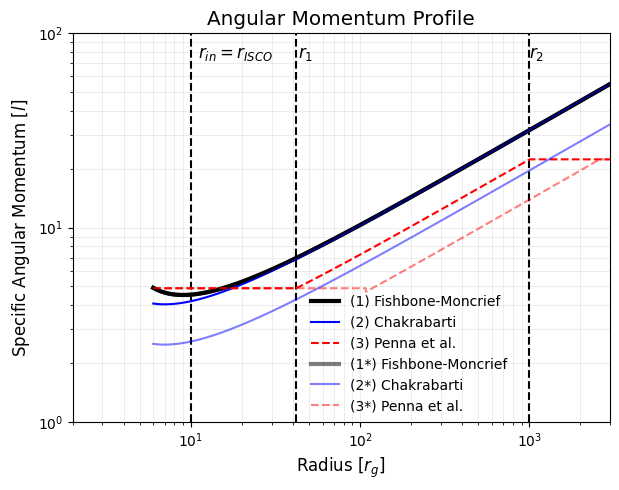

In [85]:
"""
Setting up axes and grid
------------------------
"""

plt.figure(figsize = (6.3,5))

#plt.tick_params(direction='in', grid_color='grey', grid_alpha=0.5, which = 'both')
plt.grid(color='black', linestyle='-', linewidth=0.5, alpha = 0.1, which = 'both')


"""
Plotting the important radii
----------------------------
"""

pos = 75
gap = 1

#plt.axvline(x = risco, color = 'black', linestyle = '--')
#plt.text(risco-5*gap,pos,r'$r_{ISCO}$',rotation=0, size='large')


plt.axvline(x = rin, color = 'black', linestyle = '--')
plt.text(rin+gap, pos,r'$r_{in}=r_{ISCO}$',rotation=0, size='large')

plt.axvline(x = r1, color = 'black', linestyle = '--')
plt.text(r1+gap, pos,r'$r_1$',rotation=0, size='large')
plt.axvline(x = r2, color = 'black', linestyle = '--')
plt.text(r2+gap, pos,r'$r_2$',rotation=0, size='large')
#plt.axvline(x = 1000, color = 'black', linestyle = '--', label = 'rout')
#plt.text(1000+0.1,pos,r'$r_{out}$',rotation=0, size='large')


"""
Plotting the actual profile
---------------------------
"""

rh_ind = (np.abs(r_ - rh)).argmin()

arg_th = int(n2/2)

plt.plot(r_[risco_ind:], l_fm[risco_ind:,arg_th,0], color = 'black', lw = 3, label= '(1) Fishbone-Moncrief')#*r_**(-0.5))
plt.plot(r_[risco_ind:], l_chakra[risco_ind:,arg_th ,0], color = 'blue', label= '(2) Chakrabarti')
plt.plot(r_[risco_ind:], l_penna[risco_ind:,arg_th ,0], color = 'red', label= '(3) Penna et al.', linestyle = '--')

arg_th = int(n2/8)

plt.plot(r_[risco_ind:], l_fm[risco_ind:,arg_th,0], color = 'black', lw = 3, label= '(1*) Fishbone-Moncrief', alpha = 0.5)#*r_**(-0.5))
plt.plot(r_[risco_ind:], l_chakra[risco_ind:,arg_th ,0], color = 'blue', label= '(2*) Chakrabarti', alpha = 0.5)
plt.plot(r_[risco_ind:], l_penna[risco_ind:,arg_th ,0], color = 'red', label= '(3*) Penna et al.', linestyle = '--', alpha = 0.5)

"""
Adding labels, limits, and scales
---------------------------------

"""

plt.title("Angular Momentum Profile", fontsize = 'x-large')
plt.ylabel("Specific Angular Momentum [$l$]", fontsize = 'large')
plt.xlabel(r"Radius [$r_g$]", fontsize = 'large')

plt.rcParams['figure.edgecolor']='black'
plt.rcParams['figure.frameon']= True

plt.xlim(rh,3000)
plt.ylim(1,100)
plt.xscale('log')
plt.yscale('log')

plt.legend(frameon=False, bbox_to_anchor=(0.42, 0.36), loc='upper left') #, borderaxespad=0)

plt.tight_layout()

plt.savefig("./momentumprofile.pdf", format='pdf')

## Density

### 2D Plot

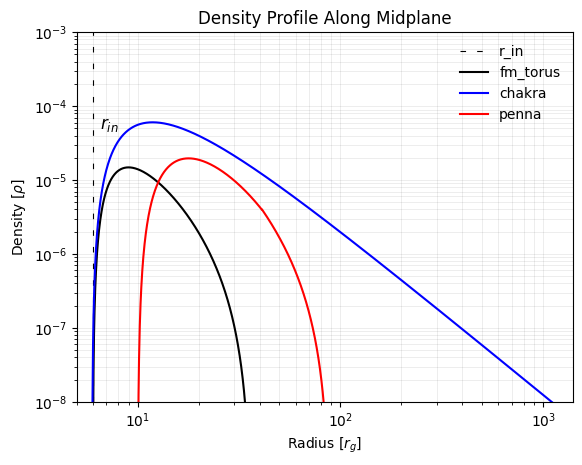

In [89]:
"""
Setting up axes and grid
------------------------
"""

#plt.tick_params(direction='in', grid_color='grey', grid_alpha=0.5, which = 'both')
plt.grid(color='black', linestyle='-', linewidth=0.5, alpha = 0.1, which = 'both')

"""
Plotting the important radii
----------------------------
"""

pos = 5*1e-5
gap = 0.5
ls = (0,(5,10))
lw = 0.8

rin=6

#plt.axvline(x = rh, color = 'black', linestyle = ls, label = 'r_h', lw = lw)
#plt.text(rh+gap, pos,r'$r_h$',rotation=0, size='large')
plt.axvline(x = rin, color = 'black', linestyle = ls, label = 'r_in', lw = lw)
plt.text(rin + gap, pos,r'$r_{in}$',rotation=0, size='large')
#plt.axvline(x = r1, color = 'black', linestyle = ls, label = 'r1', lw = lw)
#plt.text(r1 + gap, pos,r'$r_1$',rotation=0, size='large')
#plt.axvline(x = r2, color = 'black', linestyle = ls, label = 'r2', lw = lw)
#plt.text(r2 + gap, pos,r'$r_2$',rotation=0, size='large')
#plt.axvline(x = 1000, color = 'black', linestyle = ls, label = 'rout', , lw = lw)
#plt.text(1000+0.1,pos,r'$r_{out}$',rotation=0, size='large')

"""
Plotting the actual profile
---------------------------
"""

plt.plot(r_, rho_fm[:,int(n2/2),0], color = 'black', label='fm_torus')
plt.plot(r_, rho_chakra[:,int(n2/2),0], color = 'blue', label='chakra')
plt.plot(r_, rho_penna[:,int(n2/2),0], color = 'red', label='penna')

"""
Adding labels, limits, and scales
---------------------------------

"""

""" 
x-axis
"""

plt.xlim(risco-1,1400)
plt.xscale('log')
plt.xlabel("Radius [$r_g$]")


"""
y-axis
"""
plt.ylabel(r"Density [$\rho$]")
plt.ylim(1e-8,1e-3)
plt.yscale('log')

"""
title
"""
plt.title(r"Density Profile Along Midplane")

"""
Line at 1 - enthalpy must be above 1 within the accretion disk
"""

#plt.plot(r_, np.ones_like(r_), color = 'grey', alpha = 0.5)

plt.legend(frameon = False)


### Contour Plots

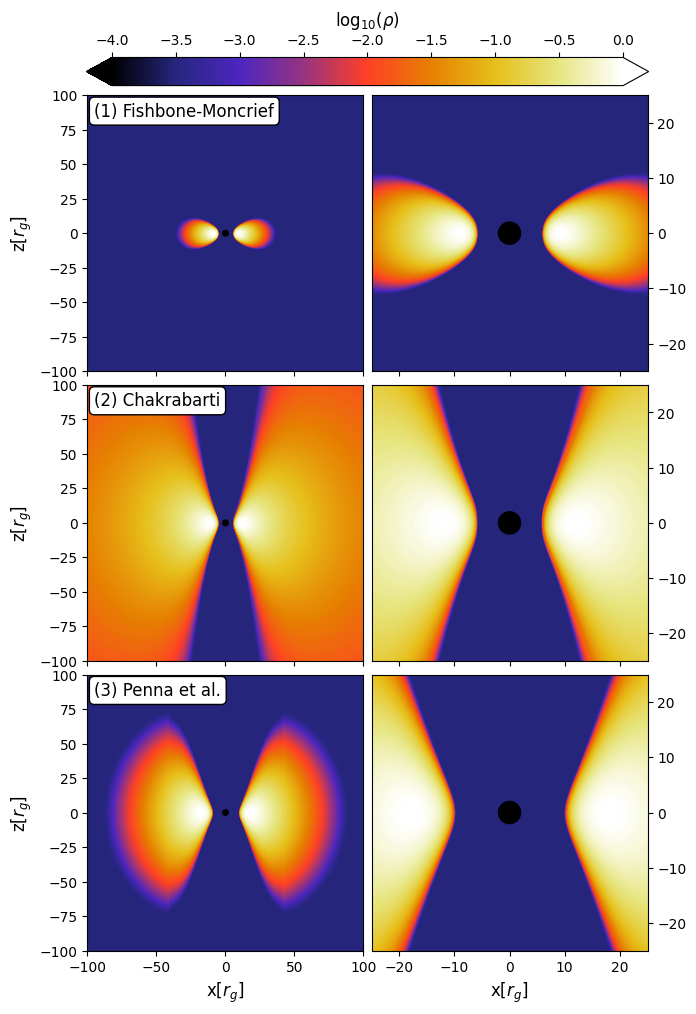

In [90]:
import warnings
warnings.filterwarnings("ignore")

mpl.rcParams['xtick.direction'] = "out"
mpl.rcParams['ytick.direction'] = "out"

cmap = 'CMRmap'
clr = 'white'

rows = 3
cols = 2

density_floor = 10**-3.5

x = r[:,:,0]*np.sin(th[:,:,0])
y = r[:,:,0]*np.cos(th[:,:,0])

fm_m = np.max(np.nan_to_num(rho_fm)*(r>5))
c_m = np.max(np.nan_to_num(rho_chakra)*(lam>5.5))
p_m = np.max(np.nan_to_num(rho_penna)*(lam>5.5))

q1 = np.log10(np.nan_to_num(rho_fm)*(r>5)/fm_m + density_floor)
q2 = np.log10(np.nan_to_num(rho_chakra)*(lam>5.5)/c_m + density_floor)
q3 = np.log10(np.nan_to_num(rho_penna)*(lam>5.5)/p_m + density_floor)

qs = [q1, q2, q3]

fmin = np.log10(1e-4)
fmax = np.log10(1)
levels = np.linspace(fmin,fmax,200)
cb_ticks = np.round_(np.linspace(fmin,fmax, 9),decimals = 3)

p1 = 100
p2 = 25

width = 3.5

fig, axs = plt.subplots(rows,cols, figsize=(cols*width,rows*width), sharex = 'col')#,gridspec_kw={'height_ratios': [3, 2]})


for i in range(rows):
    for j in range(cols):
        CS1 = axs[i,j].contourf(x, y, qs[i][:,:,0], levels=levels, extend = 'both', cmap = cmap)
        for c in CS1.collections:
            c.set_edgecolor("face")
        CS2 = axs[i,j].contourf(-x, y, qs[i][:,:,0], levels=levels, extend = 'both', cmap = cmap)
        for c in CS2.collections:
            c.set_edgecolor("face")
        #axs[i,j].contour(x, y, qs[i][:,:,0], [0.00001], color = clr)
        #axs[i,j].contour(-x, y, qs[i][:,:,0], [0.00001], color = clr)
        
        axs[i,j].set_aspect('equal')
        circle = plt.Circle((0, 0), rh, color ='black')
        axs[i,j].add_patch(circle)
    
    axs[i,1].set_xlim(-p2, p2)
    axs[i,1].yaxis.set_ticks_position('right')
    axs[i,1].set_ylim(-p2, p2)
        
    axs[i,0].set_xlim(-p1, p1)
    axs[i,0].set_ylim(-p1, p1)
    axs[i,0].set_ylabel(r'z[$r_g$]', fontsize='large')
        
axs[2,0].set_xlabel(r'x[$r_g$]', fontsize='large')
axs[2,1].set_xlabel(r'x[$r_g$]', fontsize='large')

axs[0,0].text(-95,95,"(1) Fishbone-Moncrief",bbox=dict(boxstyle="round", fc="w", ec="k"),
        size="large", color="black",horizontalalignment="left", verticalalignment="top")

axs[1,0].text(-95,95,"(2) Chakrabarti",bbox=dict(boxstyle="round", fc="w", ec="k"),
        size="large", color="black",horizontalalignment="left", verticalalignment="top")

axs[2,0].text(-95,95,"(3) Penna et al.",bbox=dict(boxstyle="round", fc="w", ec="k"),
        size="large", color="black",horizontalalignment="left", verticalalignment="top")

plt.tight_layout(h_pad = 0.1, w_pad = 0.1)

cbar = fig.colorbar(CS1, location = 'top', ax = axs, shrink = 1, pad = 0.01, fraction = 0.1)
cbar.ax.set_title(r'$\log_{10}(\rho)$')
cbar.set_ticks(cb_ticks)

#plt.savefig("./density_profiles.png", format="png", dpi=250)

In [ ]:
np.max(q1[:,int(n2/2),0])

m = (np.abs(q1[:,int(n2/2),0] - np.max(q1[:,int(n2/2),0]))).argmin()
print("FM Max Density: %s" %q1[m,int(n2/2),0])
print("Radius: %s" %r_[m])

m = (np.abs(q2[:,int(n2/2),0] - np.max(q2[:,int(n2/2),0]))).argmin()
print("Power Law Max Density: %s" %q2[m,int(n2/2),0])
print("Radius: %s" %r_[m])

m = (np.abs(q3[:,int(n2/2),0] - np.max(q3[:,int(n2/2),0]))).argmin()
print("Modified Powerlaw Max Density: %s" %q3[m,int(n2/2),0])
print("Radius: %s" %r_[m])

In [ ]:
plt.rcParams['xtick.direction'] = "in"
plt.rcParams['ytick.direction'] = "in"

## Angular Momentum Profile Comparison

In [ ]:
"""
Setting up axes and grid
------------------------
"""

#plt.tick_params(direction='in', grid_color='grey', grid_alpha=0.5, which = 'both')
plt.grid(color='black', linestyle='-', linewidth=0.5, alpha = 0.1, which = 'both')


"""
Plotting the important radii
----------------------------
"""

pos = 15
gap = 0.5

plt.axvline(x = risco, color = 'black', linestyle = '--')
plt.text(risco-5*gap,pos,r'$r_{ISCO}$',rotation=0, size='large')
plt.axvline(x = rin, color = 'black', linestyle = '--')
plt.text(rin+gap,pos,r'$r_{in}$',rotation=0, size='large')
plt.axvline(x = r1, color = 'black', linestyle = '--')
plt.text(r1+gap,pos,r'$r_1$',rotation=0, size='large')
plt.axvline(x = r2, color = 'black', linestyle = '--')
plt.text(r2+gap,pos,r'$r_2$',rotation=0, size='large')
#plt.axvline(x = 1000, color = 'black', linestyle = '--', label = 'rout')
#plt.text(1000+0.1,pos,r'$r_{out}$',rotation=0, size='large')


"""
Plotting the actual profile
---------------------------
"""

rh_ind = (np.abs(r_ - rh)).argmin()

arg_th = int(n2/8)

plt.plot(r_[risco_ind:], l[risco_ind:,arg_th,0], color = 'darkred', label= 'Fishbone-Moncrief')#*r_**(-0.5))
plt.plot(r_[risco_ind:], l_pen[risco_ind:,arg_th ,0], color = 'orange', label= 'Penna et al.')
plt.plot(r_[risco_ind:], l_chakra[risco_ind:,arg_th ,0], color = 'navy', label= 'Chakrabarti')

"""
Adding labels, limits, and scales
---------------------------------

"""

plt.title("Angular Momentum Profile")
plt.ylabel("Angular Momentum [$l$]")
plt.xlabel(r"Radius [$r_g$]")

plt.rcParams['figure.edgecolor']='black'
plt.rcParams['figure.frameon']= True

plt.xlim(rh,3000)
plt.ylim(1,100)
plt.xscale('log')
plt.yscale('log')

plt.legend(frameon=False)

## Enthalpy Comparison + Disk Boundary

In [ ]:
np.max(rho_fm)

## Initial Density Conditions

In [ ]:
import warnings
warnings.filterwarnings("ignore")

mpl.rcParams['xtick.direction'] = "out"
mpl.rcParams['ytick.direction'] = "out"

cmap = 'CMRmap_r'
clr = 'white'

rows = 3
cols = 2

density_floor = 0.0000001

x = r[:,:,0]*np.sin(th[:,:,0])
y = r[:,:,0]*np.cos(th[:,:,0])

rho_fm_ = np.nan_to_num(rho_fm*10000000)*(r>5) + density_floor
#rho_fm_ = np.nan_to_num(rho_fm/10)*(r>5) + density_floor
rho_chakra_ = np.nan_to_num(rho_chakra*1000)*(lam>5.5) + density_floor
rho_penna_ = np.nan_to_num(rho_penna*1000)*(lam>5.5) + density_floor

q1 = np.log10(rho_fm_)
q2 = np.log10(rho_chakra_)
q3 = np.log10(rho_penna_)

qs = [q1, q2, q3]

fmin = np.log10(0.00001)
fmax = np.log10(1)
levels = np.linspace(fmin,fmax,500)
cb_ticks = np.round_(np.linspace(fmin,fmax, 5),decimals = 3)

p1 = 100
p2 = 25

width = 3.5

fig, axs = plt.subplots(rows,cols, figsize=(cols*width,rows*width), sharex = 'col')#,gridspec_kw={'height_ratios': [3, 2]})


for i in range(rows):
    for j in range(cols):
        CS1 = axs[i,j].contourf(x, y, qs[i][:,:,0], levels=levels, extend = 'both', cmap = cmap)
        axs[i,j].contourf(-x, y, qs[i][:,:,0], levels=levels, extend = 'both', cmap = cmap)
        #axs[i,j].contour(x, y, qs[i][:,:,0], [0.00001], color = clr)
        #axs[i,j].contour(-x, y, qs[i][:,:,0], [0.00001], color = clr)
        
        axs[i,j].set_aspect('equal')
        circle = plt.Circle((0, 0), rh, color ='black')
        axs[i,j].add_patch(circle)
    
    axs[i,1].set_xlim(-p2, p2)
    axs[i,1].yaxis.set_ticks_position('right')
    axs[i,1].set_ylim(-p2, p2)
        
    axs[i,0].set_xlim(-p1, p1)
    axs[i,0].set_ylim(-p1, p1)
    axs[i,0].set_ylabel(r'z[$r_g$]')
        
axs[2,0].set_xlabel(r'x[$r_g$]')
axs[2,1].set_xlabel(r'x[$r_g$]')

plt.tight_layout(h_pad = 0.1, w_pad = 0.1)

cbar = fig.colorbar(CS1, location = 'top', ax = axs, shrink = 1, pad = 0.01, fraction = 0.1)
cbar.ax.set_title(r'$\log_{10}(\rho)$')
cbar.set_ticks(cb_ticks)

In [ ]:
print(np.max(10**q1))
print(np.max(10**q2))
print(np.max(10**q3))

## Initial + Final Bernoulli Parameters

## Mass Accretion Rate Comparison